In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # data manipulation
import pickle # data storage and retrieval
import gensim # doc2vec model
import sklearn.metrics # cosine similarity
import lucem_illud_2020 # for divergence calculation
import nltk # for divergence calculation
import scipy.stats # for divergence calculation, correlation calculation
from collections import defaultdict # for handling dictionary more easily
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
from nltk.corpus import wordnet as wn # getting wordnet antonyms
from ksvd import ApproximateKSVD # discourse atom model
import math # discourse atom model
from itertools import permutations # for forward stepwise subset
import wikipediaapi # for getting wikipedia page easily
import lucem_illud_2020 # for word tokenizing
import sklearn.feature_extraction # for TFIDF
from nltk.corpus import stopwords # to customize stopwords

# Loading Data

In [2]:
# getting the data created from `Data Accumulation and Cleaning.ipynb`
df = pd.read_pickle('data/tokenized_data.pkl')
author_document_count = pd.read_csv('data/author_documents_count.csv')
with open('data/annon_doc_dict', 'rb') as f:
    annon_doc_dict = pickle.load(f)

## concatenating survey data

Note that I am not saving this anywhere to confirm with annonymity agreement

In [3]:
# link the annonimized author ID to the survey IDs
double_blind = pd.read_csv('rawdata/survey/doubleBlind.csv', index_col=0)
double_blind.columns = ['surveyCode', 'author']
author_documents_count = pd.read_csv('data/author_documents_count.csv')
survey_result = author_documents_count.merge(double_blind)

# get the survey results and merge it with the annonimized author ID
survey_raw = pd.read_csv('rawdata/survey/data_mass_2018-08-30_18-40-09.csv')
survey_raw = survey_raw.rename(columns={'Unnamed: 0':'surveyCode'})
survey_result = survey_result.merge(survey_raw)

# only subset the columns to use
survey_result = survey_result[['author', 'docnum', 'abstract_docnum', 'surveyCode',
                               't_cmpt', 't_comp', 't_ctxt', 't_ess', 't_evo', 't_hol', 't_lg', 't_mth',
                               't_nat', 't_neur', 't_perc', 't_rat', 't_rch', 't_rlsm', 't_soc', 't_univ']]

# relabeling to the acutal variable names
survey_result.columns = ['author', 'docnum', 'abstract_docnum', 'surveyCode',
                         'competence', 'computer', 'context', 'essentialism', 'evolution', 'holism', 'language', 'math',
                         'nature', 'neurobiology', 'perception', 'rationality', 'reach', 'realism', 'society', 'universality']
# free up some memory
del survey_raw

# Building the Survey Dimension

In [14]:
d2v_whole = gensim.models.Doc2Vec.load('models/d2v_whole')

In [53]:
# this function is from the weekly notebooks, but they were not in lucem_illud_2020, so I am redefining it here
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

# simple helper function to subtract the normalized vectors
def dimension_raw(model, positive, negative):
    return normalize(positive) - normalize(negative)
    
# this function is from lucem_illud_2020, but somehow the function does not work so I am redefining it here
def Divergence(corpus1, corpus2, difference="KS"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

# function to build the survey dimensions and calculate various metrics about the anchor vector
def get_survey_dimensions(survey_result_df, doc_df, annon_doc_dict, model, var_lst, cutoff, fast=False):
    # initialize empty lists to store the information
    neg_author_lens = []
    pos_author_lens = []
    anchors_cos_sim = []
    num_overlap_docs = []
    num_all_docs = []
    overlap_doc_proportions = []
    anchors_ks = []
    dimensions = []
    for var in var_lst:
        # get the list of authors that fits the criterion
        negative_authors = list(survey_result_df[survey_result_df[var] <= cutoff]['author'])
        positive_authors = list(survey_result_df[survey_result_df[var] >= (100 - cutoff)]['author'])
        # append the length
        neg_author_lens.append(len(negative_authors))
        pos_author_lens.append(len(positive_authors))
        
        # average the author vectors for all authors identified above to get the anchor vectors
        positives_anchor = np.average(np.array([model[x] for x in positive_authors]), axis=0)
        negatives_anchor = np.average(np.array([model[x] for x in negative_authors]), axis=0)
        # add the cosine similarities between anchor vectors
        anchors_cos_sim.append(sklearn.metrics.pairwise.cosine_similarity(positives_anchor.reshape(1,-1),
                                                                          negatives_anchor.reshape(1,-1))[0][0])
        
        # the corpora building is insanely slow, so I created option to not calculate it in the function
        if not fast:
            # get the set of documents written by the authors identified above
            neg_doc_set, neg_authors_corpus = get_corpus_from_authors(author_lst=negative_authors,
                                                                      df=doc_df,
                                                                      annon_doc_dict=annon_doc_dict)
            pos_doc_set, pos_authors_corpus = get_corpus_from_authors(author_lst=positive_authors,
                                                                      df=doc_df,
                                                                      annon_doc_dict=annon_doc_dict)
            # append the metrics based on the corpus
            num_overlap_docs.append(len(neg_doc_set & pos_doc_set))
            num_all_docs.append(len(neg_doc_set | pos_doc_set))
            overlap_doc_proportions.append(len(neg_doc_set & pos_doc_set) / len(neg_doc_set | pos_doc_set))
            anchors_ks.append(Divergence(corpus1=neg_authors_corpus,
                                         corpus2=pos_authors_corpus,
                                         difference='KS'))
        # build the survey dimension and add it to list
        dimensions.append(dimension_raw(model=model, positive=positives_anchor, negative=negatives_anchor))
    # create dataframe based on results and return it
    if not fast:
        df = pd.DataFrame(list(zip(var_lst, neg_author_lens, pos_author_lens, anchors_cos_sim, 
                                   num_overlap_docs, num_all_docs, overlap_doc_proportions,
                                   anchors_ks, dimensions)), 
                          columns =['var_name', 'neg_author_len', 'pos_author_len', 'cos_sim', 
                                    'num_overlap_docs', 'num_all_docs', 'overlap_doc_proportion',
                                    'ks', 'dimension'])
    else:
        df = pd.DataFrame(list(zip(var_lst, neg_author_lens, pos_author_lens, anchors_cos_sim, dimensions)), 
                          columns =['var_name', 'neg_author_len', 'pos_author_len', 'cos_sim', 'dimension'])
    return df

# get all documents that is related to authors
def get_corpus_from_authors(author_lst, df, annon_doc_dict):
    doc_lst = []
    for author in author_lst:
        doc_lst += annon_doc_dict[author]
    # return the sum of all document's normalized words
    return set(doc_lst), df[df['wos_id'].isin(lst)]['normalized_words_standard'].sum()

In [82]:
%%time
# build the main dimension used for analysis
var_lst = list(survey_result.columns)[4:]
dimension_df = get_survey_dimensions(survey_result_df=survey_result,
                                     doc_df=df,
                                     annon_doc_dict=annon_doc_dict,
                                     model=d2v_whole,
                                     var_lst=var_lst,
                                     cutoff=5)

Wall time: 19min 40s


In [77]:
# mean similarities of anchor vectors
dimension_df['cos_sim'].mean()

0.7621478885412216

In [78]:
# mean overlap proportion of documents written by author in anchor vectors
dimension_df['overlap_doc_proportion'].mean()

0.00078930540517662

In [7]:
# function for projecting the author vectors to survey dimension
def project_survey_dimension(survey_result_df, model, dimension_df):
    projections = defaultdict(list)
    for author in survey_result_df['author']:
        author_vec = model[author]
        for _, row in dimension_df.iterrows():
            projections[row['var_name']].append(sklearn.metrics.pairwise.cosine_similarity(author_vec.reshape(1,-1),
                                                                                           row['dimension'].reshape(1,-1))[0][0])
    return projections

In [19]:
# project the author vectors for each survey dimension and add the result to the dataframe
projections = project_survey_dimension(survey_result_df=survey_result,
                                       model=d2v_whole, dimension_df=dimension_df)
for var, projection in projections.items():
    colname = var + '_projection'
    survey_result[colname] = projection

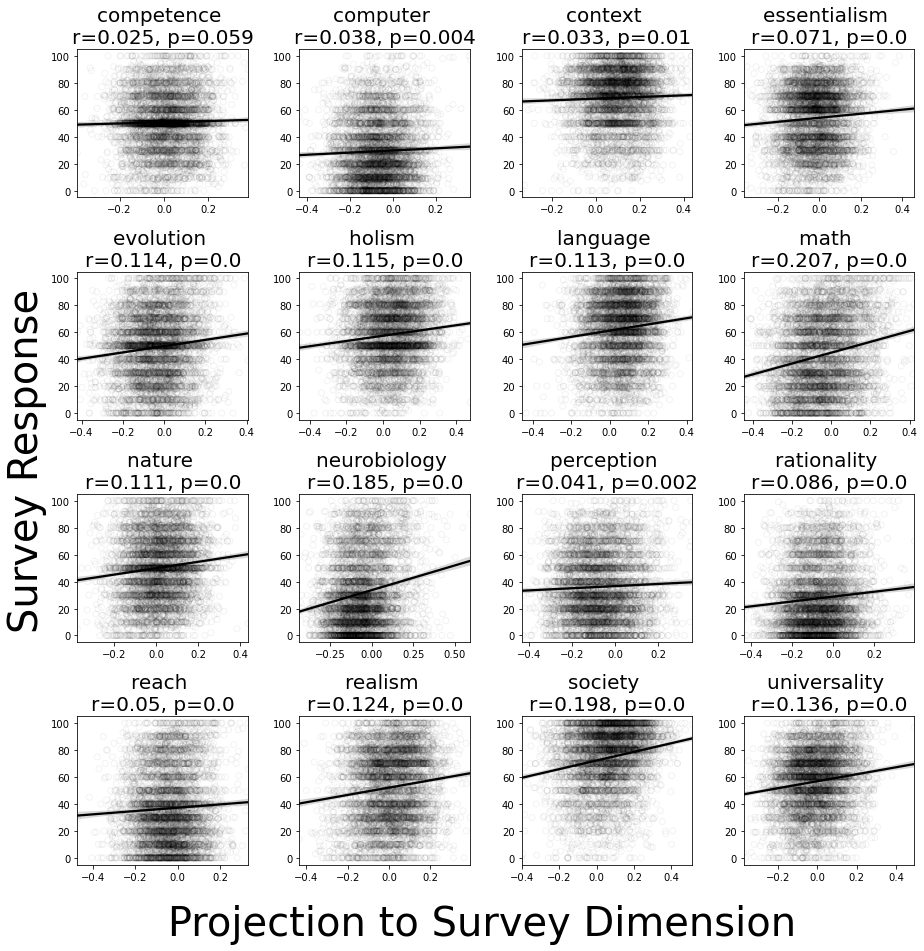

In [30]:
# plotting correlation between survey response and projections
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
idx = 0
for y in range(4):
    for x in range(4):
        var = var_lst[idx]
        projection_name = var + '_projection'
        coer = np.round(scipy.stats.pearsonr(survey_result[projection_name], survey_result[var]), 3)
        sns.regplot(data = survey_result, y=var, x=projection_name,
                    scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
                    line_kws={'color':'black'},
                    ax=ax[y][x])
        ax[y][x].set_title(f'{var} \nr={coer[0]}, p={coer[1]}', size=20)
        ax[y][x].set_xlabel('')
        ax[y][x].set_ylabel('')
        idx += 1
fig.text(0.5, 0.06, 'Projection to Survey Dimension', ha='center', size=40)
fig.text(0.06, 0.5, 'Survey Response', va='center', rotation='vertical', size=40)
plt.savefig('figures/survey_dimension_correlation_5.png');

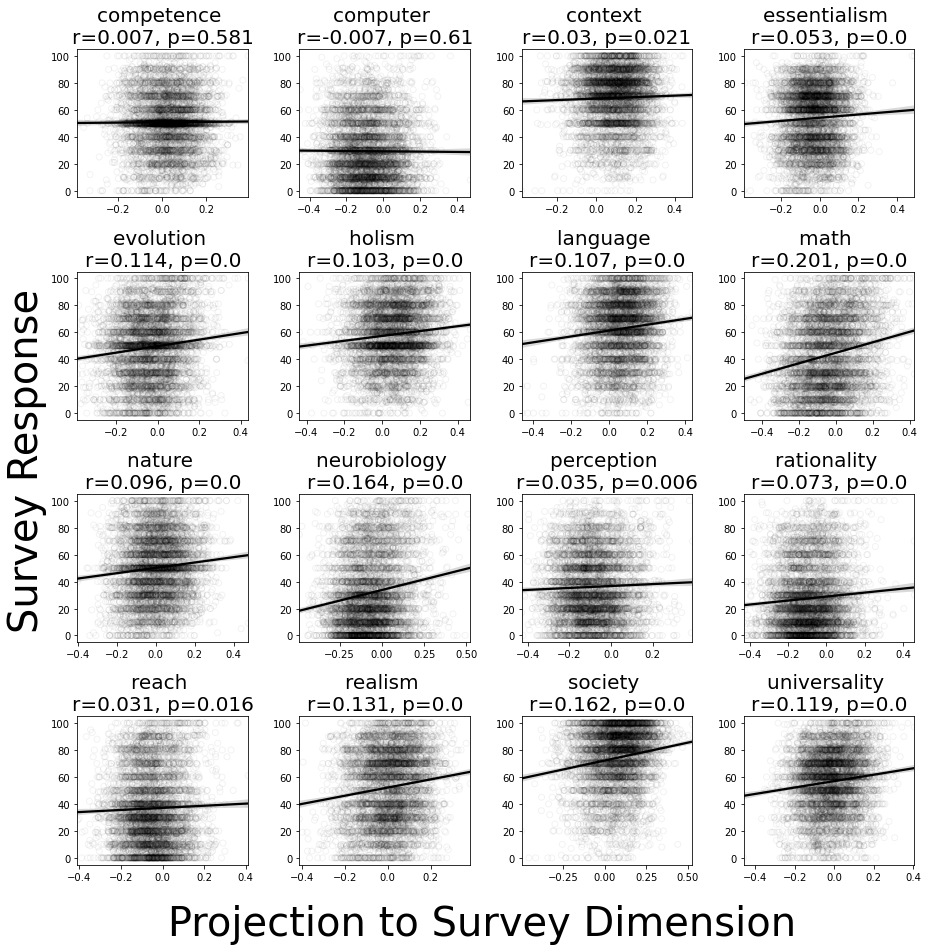

In [40]:
# create survey dimensions using cutoff=0, project the author vectors to the dimensions
# and plot the correlation between survey response and projections
dimension_df_0 = get_survey_dimensions(survey_result_df=survey_result,
                                       doc_df=df,
                                       annon_doc_dict=annon_doc_dict,
                                       model=d2v_whole,
                                       var_lst=var_lst,
                                       cutoff=0,
                                       fast=True)
projections = project_survey_dimension(survey_result_df=survey_result,
                                       model=d2v_whole, dimension_df=dimension_df_0)
for var, projection in projections.items():
    colname = var + '_projection_0'
    survey_result[colname] = projection

fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
idx = 0
for y in range(4):
    for x in range(4):
        var = var_lst[idx]
        projection_name = var + '_projection_0'
        coer = np.round(scipy.stats.pearsonr(survey_result[projection_name], survey_result[var]), 3)
        sns.regplot(data = survey_result, y=var, x=projection_name,
                    scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
                    line_kws={'color':'black'},
                    ax=ax[y][x])
        ax[y][x].set_title(f'{var} \nr={coer[0]}, p={coer[1]}', size=20)
        ax[y][x].set_xlabel('')
        ax[y][x].set_ylabel('')
        idx += 1
fig.text(0.5, 0.06, 'Projection to Survey Dimension', ha='center', size=40)
fig.text(0.06, 0.5, 'Survey Response', va='center', rotation='vertical', size=40)
plt.savefig('figures/survey_dimension_correlation_0.png');

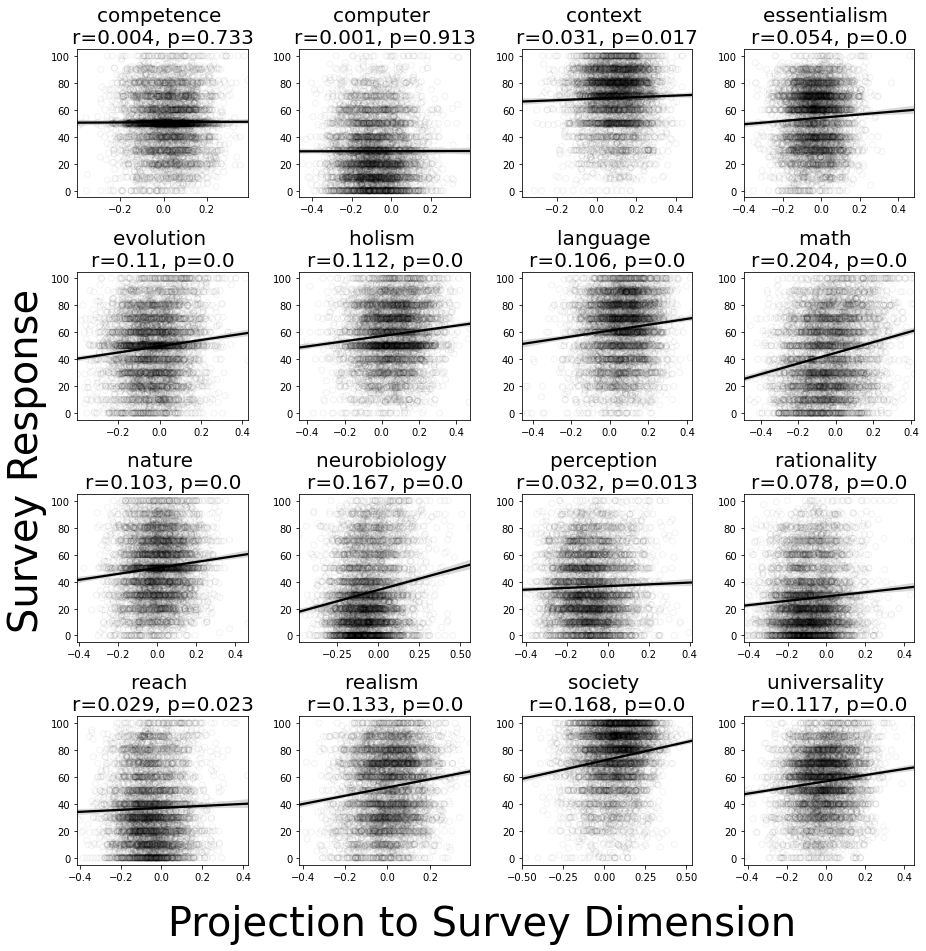

In [41]:
# create survey dimensions using cutoff=1, project the author vectors to the dimensions
# and plot the correlation between survey response and projections
dimension_df_1 = get_survey_dimensions(survey_result_df=survey_result,
                                       doc_df=df,
                                       annon_doc_dict=annon_doc_dict,
                                       model=d2v_whole,
                                       var_lst=var_lst,
                                       cutoff=1,
                                       fast=True)
projections = project_survey_dimension(survey_result_df=survey_result,
                                       model=d2v_whole, dimension_df=dimension_df_1)
for var, projection in projections.items():
    colname = var + '_projection_1'
    survey_result[colname] = projection

fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
idx = 0
for y in range(4):
    for x in range(4):
        var = var_lst[idx]
        projection_name = var + '_projection_1'
        coer = np.round(scipy.stats.pearsonr(survey_result[projection_name], survey_result[var]), 3)
        sns.regplot(data = survey_result, y=var, x=projection_name,
                    scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
                    line_kws={'color':'black'},
                    ax=ax[y][x])
        ax[y][x].set_title(f'{var} \nr={coer[0]}, p={coer[1]}', size=20)
        ax[y][x].set_xlabel('')
        ax[y][x].set_ylabel('')
        idx += 1
fig.text(0.5, 0.06, 'Projection to Survey Dimension', ha='center', size=40)
fig.text(0.06, 0.5, 'Survey Response', va='center', rotation='vertical', size=40)
plt.savefig('figures/survey_dimension_correlation_1.png');

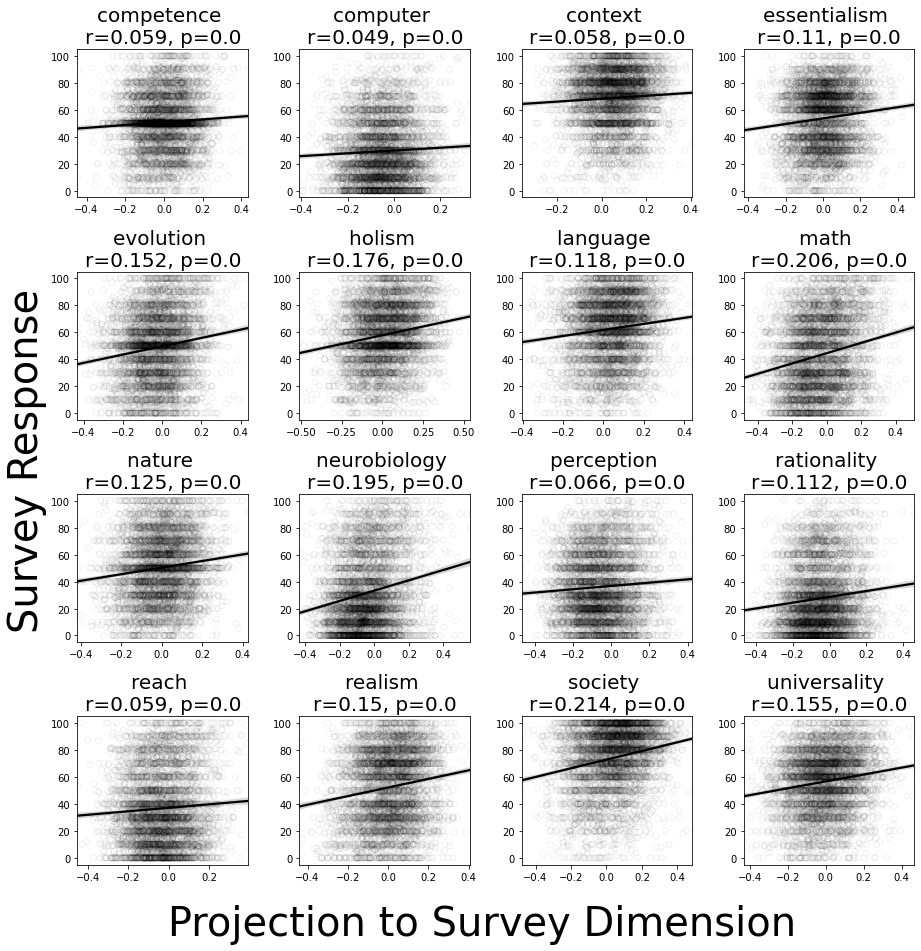

In [42]:
# create survey dimensions using cutoff=10, project the author vectors to the dimensions
# and plot the correlation between survey response and projections
dimension_df_10 = get_survey_dimensions(survey_result_df=survey_result,
                                        doc_df=df,
                                        annon_doc_dict=annon_doc_dict,
                                        model=d2v_whole,
                                        var_lst=var_lst,
                                        cutoff=10,
                                        fast=True)
projections = project_survey_dimension(survey_result_df=survey_result,
                                       model=d2v_whole, dimension_df=dimension_df_10)
for var, projection in projections.items():
    colname = var + '_projection_10'
    survey_result[colname] = projection

fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
idx = 0
for y in range(4):
    for x in range(4):
        var = var_lst[idx]
        projection_name = var + '_projection_10'
        coer = np.round(scipy.stats.pearsonr(survey_result[projection_name], survey_result[var]), 3)
        sns.regplot(data = survey_result, y=var, x=projection_name,
                    scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
                    line_kws={'color':'black'},
                    ax=ax[y][x])
        ax[y][x].set_title(f'{var} \nr={coer[0]}, p={coer[1]}', size=20)
        ax[y][x].set_xlabel('')
        ax[y][x].set_ylabel('')
        idx += 1
fig.text(0.5, 0.06, 'Projection to Survey Dimension', ha='center', size=40)
fig.text(0.06, 0.5, 'Survey Response', va='center', rotation='vertical', size=40)
plt.savefig('figures/survey_dimension_correlation_10.png');

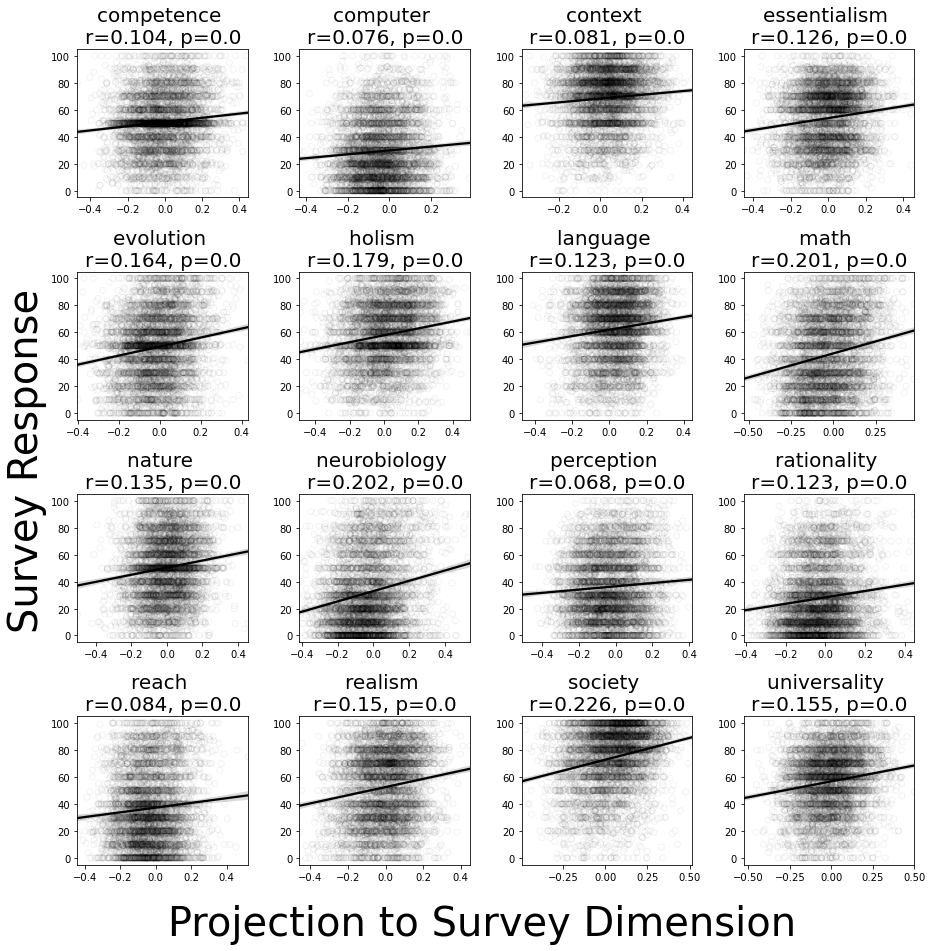

In [43]:
# create survey dimensions using cutoff=20, project the author vectors to the dimensions
# and plot the correlation between survey response and projections
dimension_df_20 = get_survey_dimensions(survey_result_df=survey_result,
                                        doc_df=df,
                                        annon_doc_dict=annon_doc_dict,
                                        model=d2v_whole,
                                        var_lst=var_lst,
                                        cutoff=20,
                                        fast=True)
projections = project_survey_dimension(survey_result_df=survey_result,
                                       model=d2v_whole, dimension_df=dimension_df_20)
for var, projection in projections.items():
    colname = var + '_projection_20'
    survey_result[colname] = projection

fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)
idx = 0
for y in range(4):
    for x in range(4):
        var = var_lst[idx]
        projection_name = var + '_projection_20'
        coer = np.round(scipy.stats.pearsonr(survey_result[projection_name], survey_result[var]), 3)
        sns.regplot(data = survey_result, y=var, x=projection_name,
                    scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
                    line_kws={'color':'black'},
                    ax=ax[y][x])
        ax[y][x].set_title(f'{var} \nr={coer[0]}, p={coer[1]}', size=20)
        ax[y][x].set_xlabel('')
        ax[y][x].set_ylabel('')
        idx += 1
fig.text(0.5, 0.06, 'Projection to Survey Dimension', ha='center', size=40)
fig.text(0.06, 0.5, 'Survey Response', va='center', rotation='vertical', size=40)
plt.savefig('figures/survey_dimension_correlation_20.png');

## Similarity between dimensions

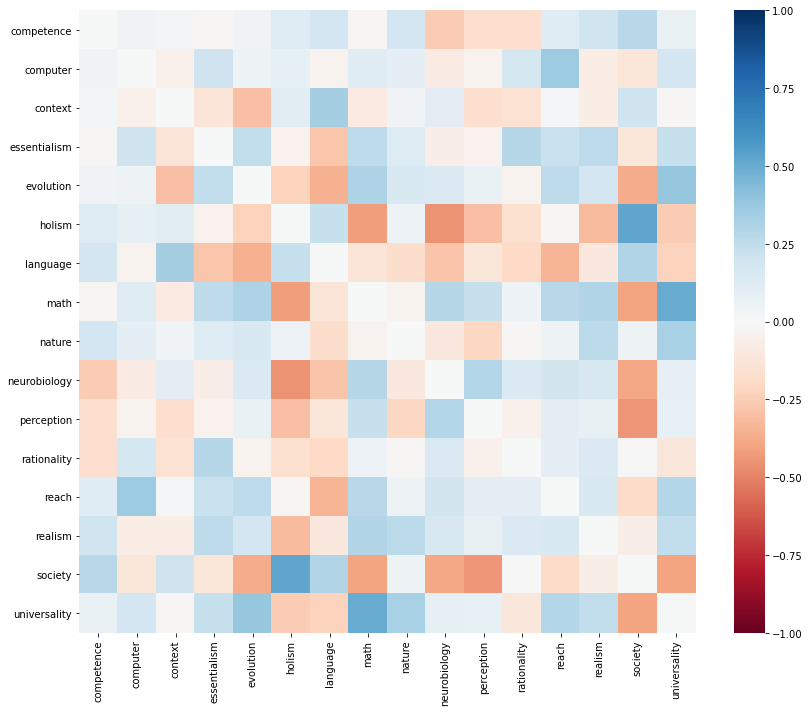

In [68]:
# build heatmap of cosine similarities between dimensions
# the code is slightly modified code from the weekly notebooks
L = []
for dimension1 in dimension_df['dimension']:
    l = []
    for dimension2 in dimension_df['dimension']:
        l.append(sklearn.metrics.pairwise.cosine_similarity(dimension1.reshape(1,-1),
                                                            dimension2.reshape(1,-1))[0][0])
    L.append(l)
M = np.array(L)
np.fill_diagonal(M, 0)
div = pd.DataFrame(M, columns = dimension_df['var_name'], index = dimension_df['var_name'])
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(div, cmap='RdBu', vmin=-1, vmax=1, ax=ax)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('figures/survey_dimension_cos_sim.png')

In [133]:
# check if any of the dimensions show high similarities with each other
(M > 0.5).any() & (M < - 0.5).any()

False

# Labeling the dimensions

## Approach 1: using wordnet antonym pairs

In [87]:
# collect all antonym pairs from nltk wordnet corpus
antonym_pairs = []
for i in wn.all_synsets():
    for j in i.lemmas(): # Iterating through lemmas for each synset.
        for j_ in j.antonyms():
            antonym_pairs.append((j.name(), j_.name()))

In [88]:
# this function is from the weekly notebooks, but they were not in lucem_illud_2020, so I am redefining it here
def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [89]:
# find all antonym pairs that were in the corpus
valid_antonym_pairs = []
for pair in antonym_pairs:
    try:
        antonym_dimension = dimension(d2v_whole, [pair[0]], [pair[1]])
        valid_antonym_pairs.append(pair)
    except:
        continue

In [90]:
# print out the number of antonym pairs
len(valid_antonym_pairs) / 2

2125.0

In [91]:
# exhaustively search thorugh all antonym pairs to build dimension
# and find the dimension that is most similiar to the survey dimension
best_pair_lst = []
best_cos_sim_lst = []
for _, row in dimension_df.iterrows():
    var_name = row['var_name']
    survey_dimension = row['dimension']
    best_cos_sim = -1
    for pair in valid_antonym_pairs:
        antonym_dimension = dimension(d2v_whole, [pair[0]], [pair[1]])
        cos_sim = sklearn.metrics.pairwise.cosine_similarity(survey_dimension.reshape(1,-1),
                                                             antonym_dimension.reshape(1,-1))[0][0]
        if cos_sim > best_cos_sim:
            best_cos_sim = cos_sim
            best_pair = pair
    best_pair_lst.append(best_pair)
    best_cos_sim_lst.append(best_cos_sim)
dimension_df['best_antonym_pair'] = best_pair_lst
dimension_df['best_antonym_pair_cos_sim'] = best_cos_sim_lst

In [92]:
# print out the results
dimension_df[['var_name', 'best_antonym_pair', 'best_antonym_pair_cos_sim']]

,var_name,best_antonym_pair,best_antonym_pair_cos_sim
0,competence,"(prefix, suffix)",0.411835
1,computer,"(unhappily, happily)",0.340816
2,context,"(unspecified, specified)",0.428701
3,essentialism,"(willingness, unwillingness)",0.334794
4,evolution,"(winged, wingless)",0.380776
5,holism,"(functioning, malfunctioning)",0.385502
6,language,"(acquit, convict)",0.404415
7,math,"(unadorned, adorned)",0.374998
8,nature,"(impure, pure)",0.347981
9,neurobiology,"(insufficiency, sufficiency)",0.426952


In [95]:
# mean of cosine similarities for reporting
dimension_df['best_antonym_pair_cos_sim'].mean()

0.38850562646985054

In [93]:
dimension_df.to_pickle('results/dimensions.pkl')

In [94]:
dimension_df.drop(columns=['dimension']).to_csv('results/dimensions.csv')

## Approach 2: building dimensions based on discourse atoms and seeing similarity

In [47]:
# these three functions are from the weekly notebooks,
# but they were not in lucem_illud_2020, so I am redefining it here

def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='../data/aksvd_models/'): #set for Alina's files, switch to where you want save the model
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

#topic diversity (% unique words among total closest 25 words to each atom)

def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

#reconstruction quality, including R^2:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

In [137]:
# building the discourse atom model
dictionary, alpha = do_aksvd(d2v_whole, 99, 5, save=True, savelocation='models/')

In [48]:
topic_diversity(d2v_whole, dictionary, top_n=25)

0.9915151515151515

In [50]:
# slightly modified function from the weekly notebooks
# to create dimensions based on atom pairs
def get_atom_combination_dimensions(atom_dict, atom_idx1, atom_idx2):
    diff = sum([normalize(atom_dict[idx]) for idx in atom_idx1]) - sum([normalize(atom_dict[idx]) for idx in atom_idx2])
    return diff

# greedily adds atom pair that gives the greatest increase in cosine similarity to the survey dimension
def forward_stepwise_subset(dimension, dictionary):
    max_cos_sim = 0
    pos_anchor_atoms = []
    neg_anchor_atoms = []
    better = True
    atom_lst = list(range(99))
    results = []
    while better:
        better = False
        cur_best_pos_atom = -1
        cur_best_neg_atom = -1
        for atom_idx in permutations(atom_lst,2):
            atom_idx1 = atom_idx[0]
            atom_idx2 = atom_idx[1]
            tmp_pos_anchor_atoms = pos_anchor_atoms + [atom_idx1]
            tmp_neg_anchor_atoms = neg_anchor_atoms + [atom_idx2]
            tmp_dimension = get_atom_combination_dimensions(dictionary, tmp_pos_anchor_atoms, tmp_neg_anchor_atoms)
            cos_sim = sklearn.metrics.pairwise.cosine_similarity(dimension.reshape(1,-1), 
                                                                 tmp_dimension.reshape(1,-1))[0][0]
            # if clause to stop the process when the criterion is met
            if cos_sim > max_cos_sim + 0.1 or (cos_sim > max_cos_sim and max_cos_sim < 0.8):
                max_cos_sim = cos_sim
                cur_best_pos_atom = atom_idx1
                cur_best_neg_atom = atom_idx2
                better = True
        if better:
            pos_anchor_atoms.append(cur_best_pos_atom)
            neg_anchor_atoms.append(cur_best_neg_atom)
            atom_lst.remove(cur_best_pos_atom)
            atom_lst.remove(cur_best_neg_atom)
            results.append((len(pos_anchor_atoms), tuple(pos_anchor_atoms), tuple(neg_anchor_atoms), max_cos_sim))
    return results

In [59]:
# function to pack the results into a dataframe
def visulaize_atom_combi(lst):
    vis_df = pd.DataFrame()
    for atom in lst[1]:
        tag = f'pos({atom})'
        vis_df[tag] = [ele[0] for ele in d2v_whole.wv.similar_by_vector(dictionary[atom],topn=20)]
    for atom in lst[2]:
        tag = f'neg({atom})'
        vis_df[tag] = [ele[0] for ele in d2v_whole.wv.similar_by_vector(dictionary[atom],topn=20)]
    return vis_df

## math

In [60]:
math_dim = np.array(dimension_df[dimension_df['var_name'] == 'math']['dimension'])[0]
atom_pairs_math = forward_stepwise_subset(math_dim, dictionary)
vis_df_math = visulaize_atom_combi(atom_pairs_math[-1])
vis_df_math.to_csv('results/math_atom.csv', index=False)
vis_df_math

,pos(40),pos(74),pos(12),pos(89),pos(81),pos(11),neg(24),neg(92),neg(43),neg(98),neg(25),neg(13)
0,loglinear,unattended,jnds,formulae,rocket,flanker,stepparent,northwest,triadic,hacen,embarrassment,certainty
1,probit,distractor,steepness,theorem,explosions,gng,grandmothers,louisiana,observational,semitransparent,disappointment,credibility
2,tobit,nontarget,discriminability,parsimony,missile,stroop,stepparents,lumpur,multiparty,cava,pity,judgments
3,legit,distracters,magnitude,guideline,strangulation,antisaccade,stepfather,arkansas,microanalysis,moist,unpleasantness,accountability
4,piecewise,redundantly,exponents,guarantees,collisions,jlap-15,grandchildren,peninsular,conversational,cadenati,powerlessness,expert
5,quad,foveal,lyapunov,specifications,oncoming,dccs,stepchild,queensland,dialog,millet,sorrow,bipolar
6,cholesky,target,discriminal,formulas,airplane,rvip,grandfathers,nevada,ethnographic,coated,humiliation,mental
7,logit,distractors,jnd,formalism,chernobyl,prosaccade,nonresidential,guatemala,dialogic,aluminium,embarrassability,seriousness
8,multisample,precue,eccentricity,hipaa,raid,mwm,noncustodial,northeast,joking,bile,malaise,evidentiary
9,gee,extrafoveal,exponent,guaranteed,trains,greyscales,grandparents,istanbul,dialogues,trianon,displeasure,judgment


In [62]:
atom_pairs_math[-1]

(6, (40, 74, 12, 89, 81, 11), (24, 92, 43, 98, 25, 13), 0.8034457)

## society

In [87]:
society_dim = np.array(dimension_df[dimension_df['var_name'] == 'society']['dimension'])[0]
atom_pairs_society = forward_stepwise_subset(society_dim, dictionary)
vis_df_society = visulaize_atom_combi(atom_pairs_society[-1])
vis_df_society.to_csv('results/society_atom.csv', index=False)
vis_df_society

,pos(69),pos(35),pos(94),pos(17),pos(98),pos(8),neg(64),neg(84),neg(54),neg(97),neg(66),neg(77)
0,paramedics,solidarity,18-item,afro,hacen,depend,morphemes,gerbils,stereopsis,j.d,hand,substitutable
1,officers,homophily,14-item,trinidadian,semitransparent,depends,affixes,chicks,luminance,carr,forelimb,conserved
2,naval,intragroup,11-item,europeans,cava,manifests,inflections,mice,achromatic,etal,arm,penetrable
3,supervisors,favoritism,33-item,hindu,moist,tied,syntactic,auratus,lightness,j.l,bimanual,disjointed
4,police,outgroup,21-item,haitian,cadenati,influenced,grammatical,pups,stereo,cole,limb,attuned
5,downsizing,ingroup,22-item,polynesian,millet,stemmed,suffixes,octodon,illumination,bennett,unimanual,impenetrable
6,navy,favouritism,28-item,anglo,coated,eased,functors,meriones,brightness,phillips,grasping,patterned
7,firefighters,marginalization,29-item,diaspora,aluminium,linked,derivational,albino,grating,r.a,elbow,relatable
8,mobbing,memberships,23-item,cuban,bile,hinges,verb,unguiculatus,gratings,richards,ocular,interwoven
9,military,prototypicality,6-item,russians,trianon,impeded,morpheme,hamsters,contours,m.e,hands,instantiated


In [88]:
atom_pairs_society[-1]

(6, (69, 35, 94, 17, 98, 8), (64, 84, 54, 97, 66, 77), 0.8026799)

## neurobiology

In [89]:
neurobiology_dim = np.array(dimension_df[dimension_df['var_name'] == 'neurobiology']['dimension'])[0]
atom_pairs_neurobiology = forward_stepwise_subset(neurobiology_dim, dictionary)
vis_df_neurobiology = visulaize_atom_combi(atom_pairs_neurobiology[-1])
vis_df_neurobiology.to_csv('results/neurobiology_atom.csv', index=False)
vis_df_neurobiology

,pos(23),pos(78),pos(80),pos(85),pos(8),neg(26),neg(24),neg(69),neg(94),neg(32)
0,doppler,putamen,mate,cs2,depend,premarital,stepparent,paramedics,18-item,discounting
1,electrocardiograms,nacc,averageness,5-s,depends,tpb,grandmothers,officers,14-item,discount
2,rectal,rostral,sociosexuality,nonreinforced,manifests,heterosexual,stepparents,naval,11-item,discounted
3,electro,midbrain,mating,miscuing,tied,transtheoretical,stepfather,supervisors,33-item,choices
4,transcutaneous,ventrolateral,rivals,120-ms,influenced,bisexual,grandchildren,police,21-item,payoffs
5,impedance,septal,ochrogaster,unreinforced,stemmed,religiosity,stepchild,downsizing,22-item,estimations
6,laser,thalamus,feminine,4-sec,eased,volunteering,grandfathers,navy,28-item,payout
7,electrocardiogram,pulvinar,masculinized,400-ms,linked,hispanic,nonresidential,firefighters,29-item,noncompletion
8,echocardiography,dorsomedial,athleticism,2-min,hinges,civic,noncustodial,mobbing,23-item,winnings
9,photoelectric,pallidum,macho,footshocks,impeded,delinquent,grandparents,military,6-item,choosing


In [90]:
atom_pairs_neurobiology[-1]

(5, (23, 78, 80, 85, 8), (26, 24, 69, 94, 32), 0.80030394)

## universality

In [91]:
universality_dim = np.array(dimension_df[dimension_df['var_name'] == 'universality']['dimension'])[0]
atom_pairs_universality = forward_stepwise_subset(universality_dim, dictionary)
vis_df_universality = visulaize_atom_combi(atom_pairs_universality[-1])
vis_df_universality.to_csv('results/universality_atom.csv', index=False)
vis_df_universality

,pos(39),pos(59),pos(93),pos(32),pos(40),pos(46),pos(64),pos(31),pos(67),pos(1),neg(51),neg(71),neg(76),neg(35),neg(94),neg(72),neg(95),neg(34),neg(0),neg(98)
0,rectangles,metamemory,neurotransmitters,discounting,loglinear,contextually,morphemes,poorer,required,pathways,eighties,poetic,anticonvulsant,solidarity,18-item,vocalization,discriminably,links,useful,hacen
1,cubes,retrieval,5ht,discount,probit,socially,affixes,improved,able,subpopulations,1960s,literary,benzodiazepines,homophily,14-item,laughter,acronyms,associations,effective,semitransparent
2,cube,recollective,glutamate,discounted,tobit,highly,inflections,lower,designed,phenotypes,1950s,narrative,psychostimulants,intragroup,11-item,vocal,audiences,relationship,feasible,cava
3,polygons,foks,neurotransmission,choices,legit,minimally,syntactic,enhanced,encouraged,taxa,2000s,poetry,naltrexone,favoritism,33-item,vocalizations,proverbs,differences,suitable,moist
4,dots,episodic,gaba,payoffs,piecewise,manner,grammatical,poorest,helps,subprocesses,1970s,archetypal,clonidine,outgroup,21-item,intonation,dualisms,contribution,promising,cadenati
5,triangles,hypermnesia,orexigenic,estimations,quad,cognitively,suffixes,worse,enables,etiologies,fifties,poet,acamprosate,ingroup,22-item,beats,clutches,impact,valuable,millet
6,rectangle,autobiographic,adenosine,payout,cholesky,behaviorally,functors,reduced,unable,subregions,thirties,hamlet,sildenafil,favouritism,28-item,speech,viewpoints,linkages,viable,coated
7,mazes,recollection,monoamine,noncompletion,logit,easily,derivational,lowered,allowed,pathophysiologies,twentieth,tales,valproate,marginalization,29-item,phonation,natures,link,efficient,aluminium
8,horizontally,encoding,biogenic,winnings,multisample,interpersonally,verb,higher,needed,subsystems,1940s,madness,anxiolytics,memberships,23-item,metronome,constituencies,association,worthwhile,bile
9,geometric,overgeneral,neurotransmitter,choosing,gee,perceptually,morpheme,greater,helped,clusterings,1930s,emmanuel,diazepam,prototypicality,6-item,vocalisations,emblems,interrelationships,helpful,trianon


In [130]:
atom_pairs_universality[5]

(6, (39, 59, 93, 32, 40, 46), (51, 71, 76, 35, 94, 72), 0.7340834)

In [131]:
atom_pairs_universality[-1]

(10,
 (39, 59, 93, 32, 40, 46, 64, 31, 67, 1),
 (51, 71, 76, 35, 94, 72, 95, 34, 0, 98),
 0.80071574)

## realism

In [93]:
realism_dim = np.array(dimension_df[dimension_df['var_name'] == 'realism']['dimension'])[0]
atom_pairs_realism = forward_stepwise_subset(realism_dim, dictionary)
vis_df_realism = visulaize_atom_combi(atom_pairs_realism[-1])
vis_df_realism.to_csv('results/realism_atom.csv', index=False)
vis_df_realism

,pos(11),pos(19),pos(67),pos(40),pos(1),pos(45),pos(50),pos(72),pos(2),pos(12),neg(21),neg(26),neg(38),neg(91),neg(20),neg(29),neg(30),neg(43),neg(5),neg(14)
0,flanker,c.i,required,loglinear,pathways,toddlers,phobic,vocalization,oviedo,jnds,metatheoretical,premarital,therapists,tonotopic,caffeinated,abilities,ample,triadic,collections,ascending
1,gng,mdn,able,probit,subpopulations,toddler,bdd,laughter,tabriz,steepness,empiricist,tpb,therapist,laminae,soda,iq,limited,observational,datasets,pseudorandom
2,stroop,r(2,designed,tobit,phenotypes,preschoolers,phobia,vocal,dusseldorf,discriminability,contextualism,heterosexual,paraprofessional,retina,beverages,aptitudes,considerable,multiparty,ethnoracially,predefined
3,antisaccade,ci=,encouraged,legit,taxa,preterm,gad,vocalizations,hamburg,magnitude,postmodernist,transtheoretical,consultation,interconnecting,consumed,retardations,abundant,microanalysis,dataset,predetermined
4,jlap-15,f(2,helps,piecewise,subprocesses,preschool,agoraphobic,intonation,dartmouth,exponents,contextualist,bisexual,consultancy,laminar,drink,impairments,unequivocal,conversational,pedigrees,1:1
5,dccs,ci95,enables,quad,etiologies,infants,sad,beats,n=188,lyapunov,functionalism,religiosity,neophyte,gyral,cola,impairment,accumulating,dialog,representatively,deg-1
6,rvip,p(2,unable,cholesky,subregions,infancy,fearful,speech,essen,discriminal,constructivism,volunteering,consultants,subplacode,coffee,deficits,meager,ethnographic,epidemiologically,descending
7,prosaccade,r(tt,allowed,logit,pathophysiologies,fullterm,spider,phonation,prague,jnd,cognitivist,hispanic,aikido,topological,juice,i.q,marshalled,dialogic,registries,plotted
8,mwm,r(s,needed,multisample,subsystems,asd,anxiety,metronome,northwestern,eccentricity,contextualistic,civic,counselor,retinotopic,consumption,dyscalculia,growing,joking,methoddata,instantaneous
9,greyscales,r-2,helped,gee,clusterings,autism,anxious,vocalisations,waterloo,exponent,hermeneutics,delinquent,trainers,bipartite,tasting,subtests,convincing,dialogues,database,fixed


In [129]:
atom_pairs_realism[5]

(6, (11, 19, 67, 40, 1, 45), (21, 26, 38, 91, 20, 29), 0.7322971)

In [132]:
atom_pairs_realism[-1]

(10,
 (11, 19, 67, 40, 1, 45, 50, 72, 2, 12),
 (21, 26, 38, 91, 20, 29, 30, 43, 5, 14),
 0.8032228)

## holism

In [95]:
holism_dim = np.array(dimension_df[dimension_df['var_name'] == 'holism']['dimension'])[0]
atom_pairs_holism = forward_stepwise_subset(holism_dim, dictionary)
vis_df_holism = visulaize_atom_combi(atom_pairs_holism[-1])
vis_df_holism.to_csv('results/holism_atom.csv', index=False)
vis_df_holism

,pos(69),pos(24),pos(15),pos(26),pos(49),pos(59),pos(35),neg(54),neg(81),neg(45),neg(36),neg(77),neg(55),neg(3)
0,paramedics,stepparent,aphasiology,premarital,fraught,metamemory,solidarity,stereopsis,rocket,toddlers,madrs,substitutable,acquiescence,analyses
1,officers,grandmothers,inception,tpb,circumvent,retrieval,homophily,luminance,explosions,toddler,hdrs,conserved,erroneous,manovas
2,naval,stepparents,flagship,heterosexual,confronting,recollective,intragroup,achromatic,missile,preschoolers,hamilton,penetrable,fallacious,ancovas
3,supervisors,stepfather,monographs,transtheoretical,tackle,foks,favoritism,lightness,strangulation,preterm,asberg,disjointed,overconfidence,analysis
4,police,grandchildren,prolific,bisexual,dealing,episodic,outgroup,stereo,collisions,preschool,endpoint,attuned,misinterpretations,assessments
5,downsizing,stepchild,ajp,religiosity,grappling,hypermnesia,ingroup,illumination,oncoming,infants,hamd,impenetrable,misinterpretation,anovas
6,navy,grandfathers,jaba,volunteering,confront,autobiographic,favouritism,brightness,airplane,infancy,ymrs,patterned,inaccurate,investigations
7,firefighters,nonresidential,psyndex,hispanic,beset,recollection,marginalization,grating,chernobyl,fullterm,montgomery,relatable,faulty,mancovas
8,mobbing,noncustodial,scielo,civic,overcoming,encoding,memberships,gratings,raid,asd,cgi,interwoven,overgeneralization,comparisons
9,military,grandparents,psychotherapeut,delinquent,vexing,overgeneral,prototypicality,contours,trains,autism,ham,instantiated,unwarranted,analyis


In [133]:
atom_pairs_holism[5]

(6, (69, 24, 15, 26, 49, 59), (54, 81, 45, 36, 77, 55), 0.78823256)

In [96]:
atom_pairs_holism[-1]

(7, (69, 24, 15, 26, 49, 59, 35), (54, 81, 45, 36, 77, 55, 3), 0.8005318)

## evolution

In [97]:
evolution_dim = np.array(dimension_df[dimension_df['var_name'] == 'evolution']['dimension'])[0]
atom_pairs_evolution = forward_stepwise_subset(evolution_dim, dictionary)
vis_df_evolution = visulaize_atom_combi(atom_pairs_evolution[-1])
vis_df_evolution.to_csv('results/evolution_atom.csv', index=False)
vis_df_evolution

,pos(89),pos(84),pos(80),pos(21),pos(0),pos(97),pos(28),pos(27),neg(6),neg(7),neg(35),neg(51),neg(34),neg(58),neg(41),neg(96)
0,formulae,gerbils,mate,metatheoretical,useful,j.d,epidemiological,mistakenly,metastrategic,afternoons,solidarity,eighties,links,entre,erp,convinced
1,theorem,chicks,averageness,empiricist,effective,carr,morbidity,mistake,participative,08:00,homophily,1960s,associations,influencia,erps,condemn
2,parsimony,mice,sociosexuality,contextualism,feasible,etal,comorbidity,wrongly,mastery,13:00,intragroup,1950s,relationship,francaise,scalp,loves
3,guideline,auratus,mating,postmodernist,suitable,j.l,epidemiologic,erroneously,sstp,midday,favoritism,2000s,differences,demostro,p300,denies
4,guarantees,pups,rivals,contextualist,promising,cole,genetic,inaccurately,namib,18:00,outgroup,1970s,contribution,potencialmente,waveforms,skeptical
5,specifications,octodon,ochrogaster,functionalism,valuable,bennett,disorders,falsely,autonomy,noon,ingroup,fifties,impact,sociales,n2,believes
6,formulas,meriones,feminine,constructivism,viable,phillips,twin,liable,ctc,a.m.,favouritism,thirties,linkages,importante,p3,proud
7,formalism,albino,masculinized,cognitivist,efficient,r.a,health,didn\'t,gmt,afternoon,marginalization,twentieth,link,que,p3a,nicer
8,hipaa,unguiculatus,athleticism,contextualistic,worthwhile,richards,comorbidities,easiest,eaa,evenings,memberships,1940s,association,tuvo,frontocentral,literally
9,guaranteed,hamsters,macho,hermeneutics,helpful,m.e,illnesses,obliged,lgo,mornings,prototypicality,1930s,interrelationships,conducta,n1,agnostic


In [134]:
atom_pairs_evolution[5]

(6, (89, 84, 80, 21, 0, 97), (6, 7, 35, 51, 34, 58), 0.7588788)

In [98]:
atom_pairs_evolution[-1]

(8, (89, 84, 80, 21, 0, 97, 28, 27), (6, 7, 35, 51, 34, 58, 41, 96), 0.8029065)

## language

In [99]:
language_dim = np.array(dimension_df[dimension_df['var_name'] == 'language']['dimension'])[0]
atom_pairs_language = forward_stepwise_subset(language_dim, dictionary)
vis_df_language = visulaize_atom_combi(atom_pairs_language[-1])
vis_df_language.to_csv('results/language_atom.csv', index=False)
vis_df_language

,pos(64),pos(49),pos(94),pos(7),pos(35),pos(11),pos(72),pos(0),pos(98),pos(41),...,neg(81),neg(93),neg(32),neg(80),neg(85),neg(28),neg(22),neg(16),neg(91),neg(36)
0,morphemes,fraught,18-item,afternoons,solidarity,flanker,vocalization,useful,hacen,erp,...,rocket,neurotransmitters,discounting,mate,cs2,epidemiological,clues,d-,tonotopic,madrs
1,affixes,circumvent,14-item,08:00,homophily,gng,laughter,effective,semitransparent,erps,...,explosions,5ht,discount,averageness,5-s,morbidity,snapshot,transferase,laminae,hdrs
2,inflections,confronting,11-item,13:00,intragroup,stroop,vocal,feasible,cava,scalp,...,missile,glutamate,discounted,sociosexuality,nonreinforced,comorbidity,index,tilde,retina,hamilton
3,syntactic,tackle,33-item,midday,favoritism,antisaccade,vocalizations,suitable,moist,p300,...,strangulation,neurotransmission,choices,mating,miscuing,epidemiologic,measure,q2,interconnecting,asberg
4,grammatical,dealing,21-item,18:00,outgroup,jlap-15,intonation,promising,cadenati,waveforms,...,collisions,gaba,payoffs,rivals,120-ms,genetic,screener,f-,laminar,endpoint
5,suffixes,grappling,22-item,noon,ingroup,dccs,beats,valuable,millet,n2,...,oncoming,orexigenic,estimations,ochrogaster,unreinforced,disorders,information,adenosyl,gyral,hamd
6,functors,confront,28-item,a.m.,favouritism,rvip,speech,viable,coated,p3,...,airplane,adenosine,payout,feminine,4-sec,twin,insights,alanine,subplacode,ymrs
7,derivational,beset,29-item,afternoon,marginalization,prosaccade,phonation,efficient,aluminium,p3a,...,chernobyl,monoamine,noncompletion,masculinized,400-ms,health,indication,bateria,topological,montgomery
8,verb,overcoming,23-item,evenings,memberships,mwm,metronome,worthwhile,bile,frontocentral,...,raid,biogenic,winnings,athleticism,2-min,comorbidities,overview,delta(2,retinotopic,cgi
9,morpheme,vexing,6-item,mornings,prototypicality,greyscales,vocalisations,helpful,trianon,n1,...,trains,neurotransmitter,choosing,macho,footshocks,illnesses,artemis,selectin,bipartite,ham


In [135]:
atom_pairs_language[5]

(6, (64, 49, 94, 7, 35, 11), (84, 81, 93, 32, 80, 85), 0.7485306)

In [100]:
atom_pairs_language[-1]

(11,
 (64, 49, 94, 7, 35, 11, 72, 0, 98, 41, 14),
 (84, 81, 93, 32, 80, 85, 28, 22, 16, 91, 36),
 0.8038919)

# Discussion

## Subfield dimension based on wikipedia

In [184]:
# initialize the session and get the text for cognitive psychology 
wiki = wikipediaapi.Wikipedia('en')
page_cog = wiki.page('Cognitive psychology')
cog_text = page_cog.text.split('\nSee also')[0]
# get the text for cultural psychology 
page_cul = wiki.page('Cultural psychology')
cul_text = page_cul.text.split('\nSee also')[0]

In [254]:
# creating a 2 row dataframe
wiki_df = pd.DataFrame([cog_text, cul_text], columns=['text'])
wiki_df['tokenized_words'] = wiki_df['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
# normalizing text in a standard fashion (to use for other purposes)
wiki_df['normalized_words'] = wiki_df['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))
wiki_df['joined_words'] = wiki_df['normalized_words'].apply(lambda x: ' '.join(x))

In [255]:
wiki_df

,text,tokenized_words,normalized_words,joined_words
0,Cognitive psychology is the scientific study o...,"[Cognitive, psychology, is, the, scientific, s...","[cognitive, psychology, scientific, study, men...",cognitive psychology scientific study mental p...
1,Cultural psychology is the study of how cultur...,"[Cultural, psychology, is, the, study, of, how...","[cultural, psychology, study, culture, reflect...",cultural psychology study culture reflect shap...


In [288]:
# add some custom stop words to rule out some less useful words
stopword = list(stopwords.words('english'))
stopword += ['psychology', 'human', 'study', 'term', 'understand', 'science', 'think', 'include', 'mental',
            'psychologist', 'involve', 'research']

In [289]:
# calculate TFIDF score and get the TFIDF vector
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopword, norm='l2')
TFVects = TFVectorizer.fit_transform(wiki_df['joined_words'])
TFVects = TFVects.todense()

In [293]:
for idx in np.argsort(np.array(TFVects[0]))[0][::-1][:20]:
    print(TFVectorizer.get_feature_names()[idx])

cognitive
memory
information
process
knowledge
work
area
language
attention
ear
field
concept
particular
metacognition
relate
ability
individual
message
social
come


In [294]:
for idx in np.argsort(np.array(TFVects[1]))[0][::-1][:20]:
    print(TFVectorizer.get_feature_names()[idx])

culture
cultural
empathy
self
individual
society
value
people
intercultural
collectivistic
individualistic
model
population
western
different
promise
community
behavior
example
practice


In [65]:
# Build dimension using word pairs and calculate similarity with the math survey dimension
cog_cul_dim = dimension(model=d2v_whole, positives=['cognitive', 'cognition'], negatives=['cultural', 'culture'])
sklearn.metrics.pairwise.cosine_similarity(cog_cul_dim.reshape(1,-1), 
                                           math_dim.reshape(1,-1))[0][0]

0.24654016

In [96]:
# Build dimension using averaged vectors and calculate similarity with the math survey dimension
positives=['cognitive', 'cognition', 'memory', 'attention', 'metacognition']
negatives=['culture', 'cultural', 'empathy', 'society', 'intercultural']
positives_anchor = np.average(np.array([d2v_whole[x] for x in positives]), axis=0)
negatives_anchor = np.average(np.array([d2v_whole[x] for x in negatives]), axis=0)
cog_cul_dim = dimension_raw(model=d2v_whole, positive=positives_anchor, negative=negatives_anchor)
sklearn.metrics.pairwise.cosine_similarity(cog_cul_dim.reshape(1,-1), 
                                           math_dim.reshape(1,-1))[0][0]

0.32533208

In [98]:
# simple helper function for projecting to the dimensions
def project_single_dimension(survey_result_df, model, dimension):
    projections = []
    for author in survey_result_df['author']:
        author_vec = model[author]
        projections.append(sklearn.metrics.pairwise.cosine_similarity(author_vec.reshape(1,-1),
                                                                       dimension.reshape(1,-1))[0][0])
    return projections

In [99]:
# project the author vectors to the created dimension
cog_cul_projections = project_single_dimension(survey_result, d2v_whole, cog_cul_dim)

In [103]:
# project the names of subfields of psychology to the created dimension
fields = ['experimental', 'clinical', 'developmental', 'educational', 
          'school', 'forensic', 'health', 'industrial', 'organizational',
          'neuroscience', 'cognitive', 'social', 'cultural']
field_projection_to_math = [sklearn.metrics.pairwise.cosine_similarity(d2v_whole[field].reshape(1,-1),
                                                                       math_dim.reshape(1,-1))[0][0] for field in fields]

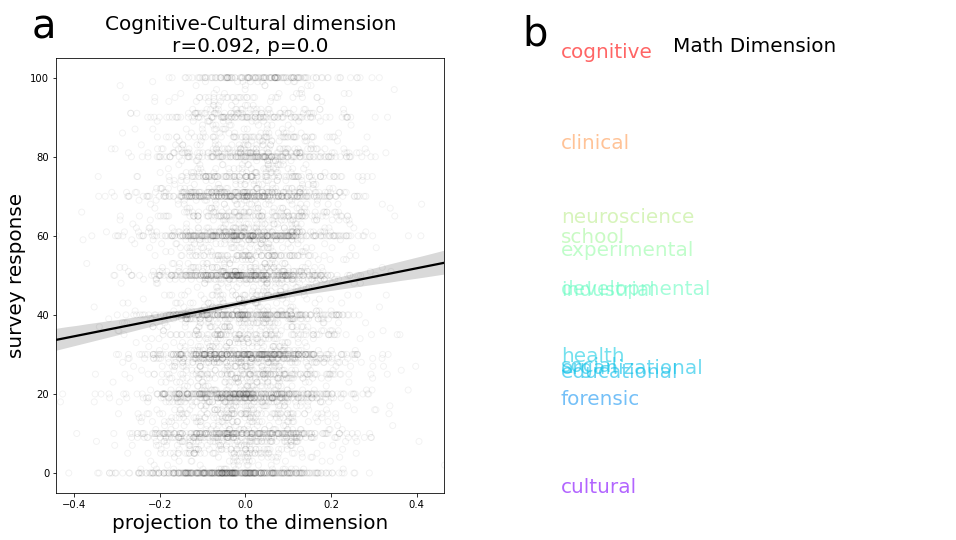

In [126]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

# plot the correlation between survey response for math and projections to the created dimension
coer = np.round(scipy.stats.pearsonr(cog_cul_projections, survey_result['math']), 3)
sns.regplot(y=survey_result['math'], x=cog_cul_projections, 
            scatter_kws={'alpha':0.05, 'facecolor':"None",
                                 'edgecolor':'black'},
            line_kws={'color':'black'}, ax=ax[0])
ax[0].set_title(f'Cognitive-Cultural dimension\nr={coer[0]}, p={coer[1]}', size=20)
ax[0].set_xlabel('projection to the dimension', size=20)
ax[0].set_ylabel('survey response', size=20)
ax[0].text(s='a', x=-0.5, y=110, size=40)

# plot the projection of subfield words to the created dimension
# note that this is modified code from the weekly notebook
x = np.array(field_projection_to_math)
y = x - x.min()
z = y / y.max()
c = list(plt.cm.rainbow(z))
ax[1].set_frame_on(False)
ax[1].set_title('Math Dimension', fontsize = 20)
for i in range(len(fields)):
    ax[1].annotate(fields[i], (0, field_projection_to_math[i]), color = c[i], alpha = 0.6, fontsize = 20)
MaxY = x.max()
MinY = x.min()
ax[1].set_ylim(MinY,MaxY)
ax[1].set_yticks(())
ax[1].set_xticks(())
ax[1].text(s='b', x=-0.1, y=MaxY + 0.01, size=40)
plt.savefig('figures/discussion.png')